**Imports**

In [ ]:
import pathlib
import numpy as np
import tensorflow as tf
import keras
from keras import *
from tensorflow.keras.optimizers import Adam
from keras.layers import *
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**Load the dataset**

In [ ]:
def load_data():
  dataset_dir=pathlib.Path('drive/MyDrive/ML/HW3/Dataset_RX')

  img_height=200
  img_width=200
  batch_size=32

  datagen = ImageDataGenerator(
      rescale = 1. / 255,\
      rotation_range=10,\
      horizontal_flip=True,\
      vertical_flip=False)

  img_generator = datagen.flow_from_directory(
      directory=dataset_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      shuffle=True,
  )

  X_arr=[]
  i=0
  img=img_generator.next()
  while(i < img_generator.n):
    for j in range(0,32):
      if(i+j < img_generator.n):
        X_arr.append(img[0][j])
        i=i+1

  X_train = np.asarray(X_arr)
  return X_train


X_train=load_data()

Found 1583 images belonging to 1 classes.


**Visualize examples**

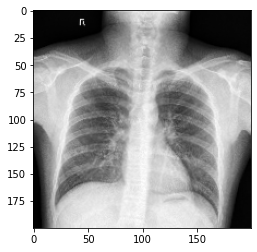

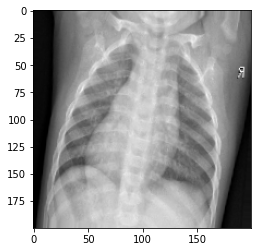

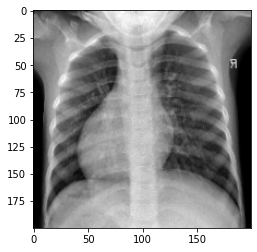

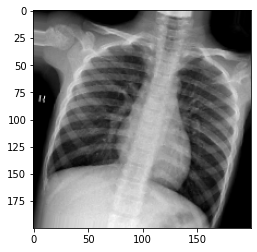

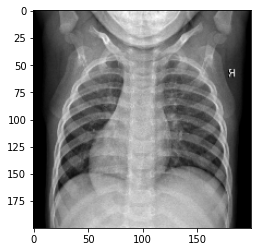

In [ ]:
n = 5

for i in range(0,n):
    image = X_train[i]
    plt.imshow(image)
    plt.show()

**Define the GAN model**

In [ ]:
class GAN():
 
    def __init__(self, latent_dim=128):

        self.img_rows = 200
        self.img_cols = 200
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
 
        optimizer = Adam(lr=0.0002, beta_1=0.5)
 
        disc_fn = self.build_discriminator_CNN
        gen_fn = self.build_generator_CNN

        # Build and compile the discriminator
        self.discriminator = disc_fn()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer, metrics=['accuracy'])

        self.latent_dim = latent_dim

        self.Goutact = 'sigmoid'   

        # Build and compile the generator
        self.generator = gen_fn()
  
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
 
        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity
        self.combined = Sequential()
        self.combined.add(self.generator)
        self.combined.add(self.discriminator)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

        self.combined.summary()
 
        # plot the models
        plot_model(self.discriminator, to_file='drive/MyDrive/ML/HW3/plots/D.png', show_shapes=True, show_layer_names=True)
        plot_model(self.generator, to_file='drive/MyDrive/ML/HW3/plots/G.png', show_shapes=True, show_layer_names=True)
        plot_model(self.combined, to_file='drive/MyDrive/ML/HW3/plots/GAN.png', show_shapes=True, show_layer_names=True)

        # Load the dataset
        self.X_train = load_data()
        
        #print(self.X_train.shape)
        #self.X_train = np.expand_dims(self.X_train, axis=3)
        #print(self.X_train.shape)

        # Training epochs
        self.epoch = 0


    def build_generator_CNN(self):

        noise_shape = (self.latent_dim,)

        model = Sequential()
        # foundation for 50x50 image
        n_nodes = 128 * 50 * 50
        model.add(Dense(n_nodes, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((50, 50, 128)))
        # upsample to 100x100
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # upsample to 200x200
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(3, (50,50), activation='sigmoid', padding='same'))

        model.summary()

        return model


    # define the standalone discriminator model
    def build_discriminator_CNN(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)

        model = Sequential()
        model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=img_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(96, (3,3), strides=(2, 2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(128, (3,3), strides=(2, 2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()

        return model


    def train(self, epochs, batch_size=128, save_interval=100, show_img=False):

        half_batch = int(batch_size / 2)
 
        last_epoch = self.epoch + epochs

        self.save_imgs(self.epoch)
        self.d_loss = []
        self.g_loss = []

        while self.epoch < last_epoch:
 
            # ---------------------
            #  Train Discriminator
            # ---------------------
 
            # Select a random half batch of images from dataset (real = 1)
            idx = np.random.randint(0, self.X_train.shape[0], half_batch)
            imgs = self.X_train[idx]
            y_imgs = np.ones((half_batch, 1))
 
            # Generate a half batch of images (fake = 0)
            noise = np.random.uniform(-1.0, 1.0, (half_batch, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            y_gen = np.zeros((half_batch, 1))
 
            # Train the discriminator
            X = np.vstack((imgs, gen_imgs))
            y = np.vstack((y_imgs, y_gen))
            d_loss = self.discriminator.train_on_batch(X, y)
            
            self.d_loss.append(d_loss[0])
 
            # ---------------------
            #  Train Generator
            # ---------------------
            noise = np.random.uniform(-1.0, 1.0, (batch_size, self.latent_dim))
 
            # The generator wants the discriminator to label the generated samples
            # as valid (real = 1)
            y_gennoise = np.ones((batch_size, 1))
 
            # Train the generator
            g_loss = self.combined.train_on_batch(noise, y_gennoise)
            self.g_loss.append(g_loss)
 
            self.epoch += 1

            # If at save interval => save generated image samples
            if self.epoch % save_interval == 0:
                # Plot the progress                
                print ( "%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (self.epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.save_imgs(self.epoch,show_img=False)
                if(str(self.epoch)[-3] == '5' or str(self.epoch - 500)[-3]=='5'):
                  self.save_imgs(self.epoch,show_img=True)
                  self.show_plot(self.epoch-500,self.epoch)
                


    def gen_imgs(self):
        cc = 9
        noise = np.random.uniform(-1.0, 1.0, (cc, self.latent_dim))
        self.imgs = self.generator.predict(noise)
 
        # Rescale images to [0,1]
        if self.Goutact=='tanh':
          self.imgs = 0.5 * self.imgs + 0.5


    def save_imgs(self, epoch, show_img=False):
        r, c = 3, 3
        self.gen_imgs()

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                self.img=self.imgs[cnt,:,:,:]
                self.img=np.reshape(self.img,[200,200,3])
                axs[i,j].imshow(self.img)
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("drive/MyDrive/ML/HW3/Generated_RX1/img_%05d.png" %(epoch))
        if show_img:
            plt.show()
        plt.close()


    def show_images(self):
        r, c = 3, 3
        self.gen_imgs()
 
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                self.img=self.imgs[cnt,:,:,:]
                self.img=np.reshape(self.img,[200,200,3])
                axs[i,j].imshow(self.img)
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.close()


    def save_model(self):
      filename = 'drive/MyDrive/ML/HW3/Models/RX1/G_model_%05d.h5' %(self.epoch)
      self.generator.save(filename)
      filename = 'drive/MyDrive/ML/HW3/Models/RX1/D_model_%05d.h5' %(self.epoch)
      self.discriminator.save(filename)
      print("Models G/%s saved." %(filename))

    def show_plot(self, start, end):
      plt.subplots()
      plt.xlim(start,end)
      plt.plot(self.d_loss, label='D loss')
      plt.plot(self.g_loss, label='G loss')
      plt.show()
      plt.close()

    def load_model(self,epoch):
      optimizer = Adam(lr=0.0002, beta_1=0.5)
      self.epoch = epoch
      filename = 'G_model_%05d.h5' %(self.epoch)
      self.generator= tf.keras.models.load_model(filename)
      filename = 'D_model_%05d.h5' %(self.epoch)
      self.discriminator= tf.keras.models.load_model(filename)
      self.discriminator.trainable = False

      self.combined = Sequential()
      self.combined.add(self.generator)
      self.combined.add(self.discriminator)
      self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
      print("Models G/%s loaded." %(filename))

**Create the GAN**

In [ ]:
gan = GAN(latent_dim=256)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 64)      1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 100, 100, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 96)        55392     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50, 50, 96)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 128)       1

**train and save the GAN**

100 [D loss: 0.653869, acc.: 65.62%] [G loss: 0.776356]
200 [D loss: 0.664236, acc.: 59.38%] [G loss: 0.809428]
300 [D loss: 0.704866, acc.: 50.00%] [G loss: 0.761155]
400 [D loss: 0.691635, acc.: 53.12%] [G loss: 0.739827]
500 [D loss: 0.279633, acc.: 90.62%] [G loss: 3.960762]


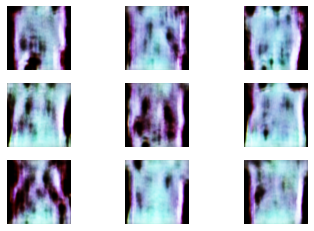

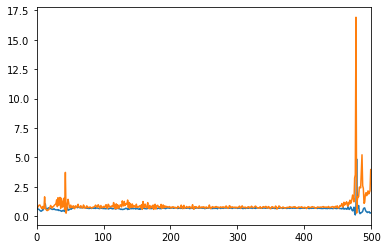

600 [D loss: 0.628496, acc.: 68.75%] [G loss: 0.855726]
700 [D loss: 0.603158, acc.: 84.38%] [G loss: 0.780886]
800 [D loss: 0.563771, acc.: 93.75%] [G loss: 0.894991]
900 [D loss: 0.558834, acc.: 81.25%] [G loss: 1.167963]
1000 [D loss: 0.476765, acc.: 90.62%] [G loss: 1.044763]


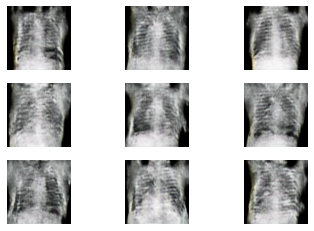

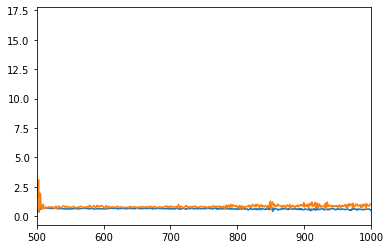

1100 [D loss: 0.116689, acc.: 100.00%] [G loss: 3.298037]
1200 [D loss: 0.446481, acc.: 81.25%] [G loss: 1.058285]
1300 [D loss: 0.355563, acc.: 93.75%] [G loss: 2.102689]
1400 [D loss: 0.392193, acc.: 87.50%] [G loss: 1.863768]
1500 [D loss: 0.362421, acc.: 90.62%] [G loss: 1.890695]


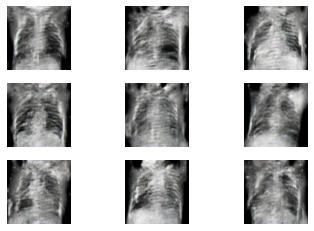

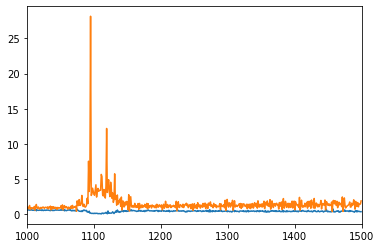

1600 [D loss: 0.394423, acc.: 84.38%] [G loss: 1.680891]
1700 [D loss: 0.413603, acc.: 78.12%] [G loss: 1.286369]
1800 [D loss: 0.253171, acc.: 96.88%] [G loss: 1.858618]
1900 [D loss: 0.451197, acc.: 78.12%] [G loss: 1.462391]
2000 [D loss: 0.488408, acc.: 71.88%] [G loss: 2.044330]


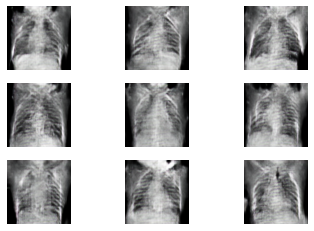

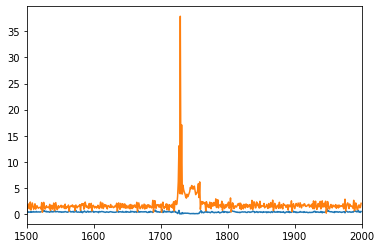

2100 [D loss: 0.364347, acc.: 81.25%] [G loss: 1.488375]
2200 [D loss: 0.379694, acc.: 84.38%] [G loss: 1.695908]
2300 [D loss: 0.301832, acc.: 93.75%] [G loss: 1.168600]
2400 [D loss: 0.452726, acc.: 87.50%] [G loss: 1.606034]
2500 [D loss: 0.351637, acc.: 84.38%] [G loss: 1.385527]


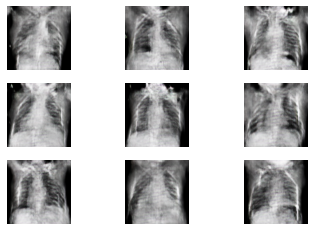

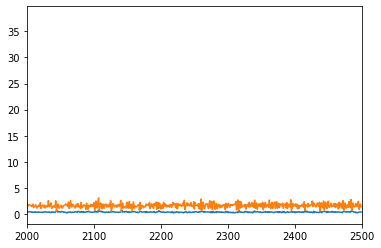

2600 [D loss: 0.329380, acc.: 87.50%] [G loss: 2.138726]
2700 [D loss: 0.001695, acc.: 100.00%] [G loss: 7.497705]
2800 [D loss: 0.000531, acc.: 100.00%] [G loss: 8.583190]
2900 [D loss: 0.000220, acc.: 100.00%] [G loss: 9.174540]
3000 [D loss: 0.000098, acc.: 100.00%] [G loss: 9.529772]


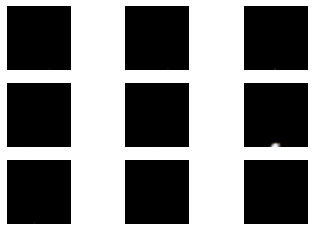

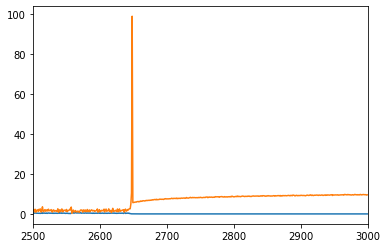

3100 [D loss: 0.000143, acc.: 100.00%] [G loss: 10.023470]
3200 [D loss: 0.000111, acc.: 100.00%] [G loss: 10.280051]
3300 [D loss: 0.000115, acc.: 100.00%] [G loss: 10.603077]
3400 [D loss: 0.000087, acc.: 100.00%] [G loss: 10.663685]
3500 [D loss: 0.000051, acc.: 100.00%] [G loss: 11.063821]


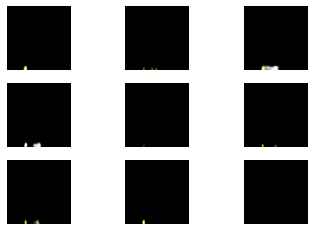

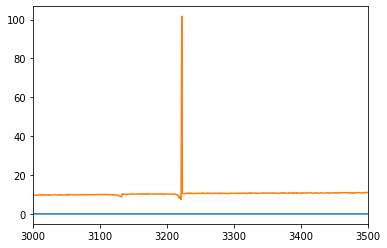

3600 [D loss: 0.000061, acc.: 100.00%] [G loss: 10.788520]
3700 [D loss: 0.000035, acc.: 100.00%] [G loss: 11.045083]
3800 [D loss: 0.000040, acc.: 100.00%] [G loss: 10.790951]
3900 [D loss: 0.000045, acc.: 100.00%] [G loss: 12.299997]
4000 [D loss: 0.000422, acc.: 100.00%] [G loss: 14.139664]


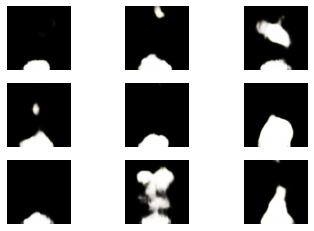

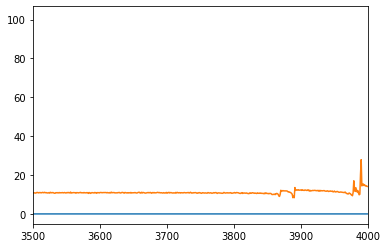

4100 [D loss: 0.045869, acc.: 96.88%] [G loss: 15.075792]
4200 [D loss: 0.357734, acc.: 93.75%] [G loss: 1.395183]
4300 [D loss: 0.272426, acc.: 93.75%] [G loss: 1.801929]
4400 [D loss: 0.276427, acc.: 90.62%] [G loss: 1.262563]
4500 [D loss: 0.259107, acc.: 93.75%] [G loss: 1.402222]


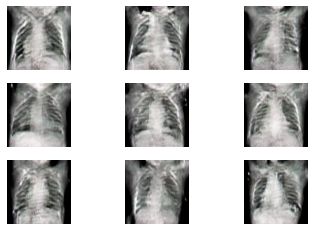

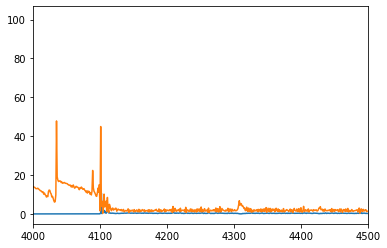

4600 [D loss: 0.292153, acc.: 90.62%] [G loss: 1.836612]
4700 [D loss: 0.343159, acc.: 87.50%] [G loss: 1.850003]
4800 [D loss: 0.205740, acc.: 93.75%] [G loss: 2.120665]
4900 [D loss: 0.212791, acc.: 96.88%] [G loss: 1.617839]
5000 [D loss: 0.266706, acc.: 93.75%] [G loss: 1.475285]


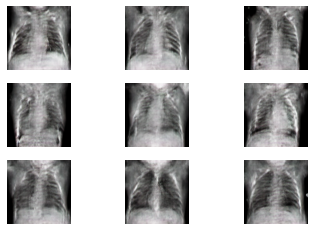

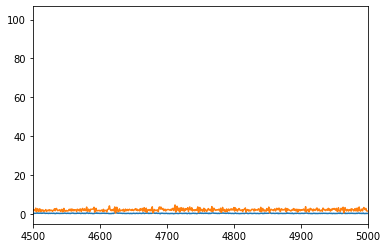

5100 [D loss: 0.191419, acc.: 96.88%] [G loss: 2.628220]
5200 [D loss: 0.345265, acc.: 93.75%] [G loss: 1.550418]
5300 [D loss: 0.150050, acc.: 96.88%] [G loss: 3.126742]
5400 [D loss: 0.224826, acc.: 93.75%] [G loss: 3.420960]
5500 [D loss: 0.415917, acc.: 78.12%] [G loss: 1.216322]


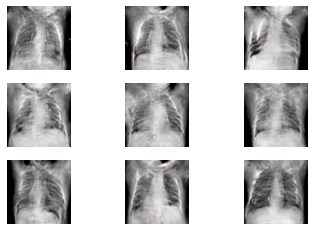

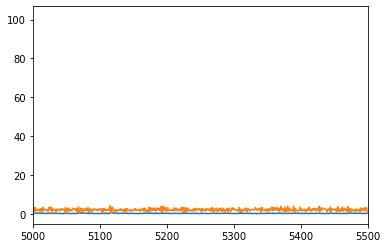

5600 [D loss: 0.238168, acc.: 87.50%] [G loss: 2.245615]
5700 [D loss: 0.003063, acc.: 100.00%] [G loss: 11.514613]
5800 [D loss: 0.004393, acc.: 100.00%] [G loss: 20.606071]
5900 [D loss: 0.003134, acc.: 100.00%] [G loss: 9.639795]
6000 [D loss: 0.001297, acc.: 100.00%] [G loss: 10.187937]


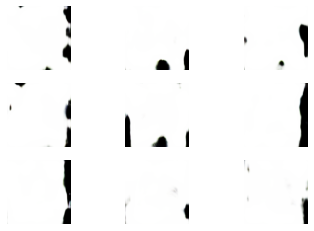

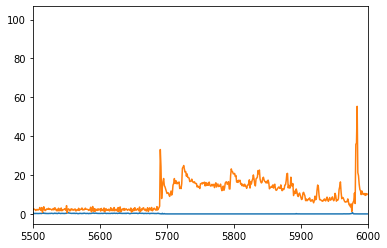

6100 [D loss: 0.000636, acc.: 100.00%] [G loss: 9.885937]
6200 [D loss: 0.083520, acc.: 100.00%] [G loss: 3.232411]
6300 [D loss: 0.046535, acc.: 100.00%] [G loss: 3.214451]
6400 [D loss: 0.149270, acc.: 96.88%] [G loss: 2.944350]
6500 [D loss: 0.145163, acc.: 96.88%] [G loss: 3.000066]


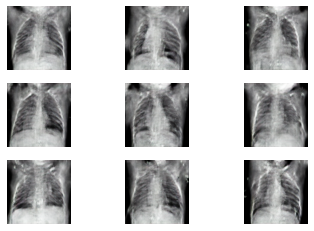

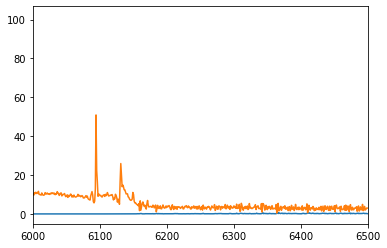

6600 [D loss: 0.248819, acc.: 84.38%] [G loss: 1.647979]
6700 [D loss: 0.106262, acc.: 100.00%] [G loss: 2.286915]
6800 [D loss: 0.104107, acc.: 100.00%] [G loss: 3.501379]
6900 [D loss: 0.226886, acc.: 90.62%] [G loss: 2.047885]
7000 [D loss: 0.137535, acc.: 100.00%] [G loss: 1.903339]


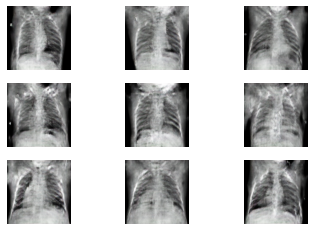

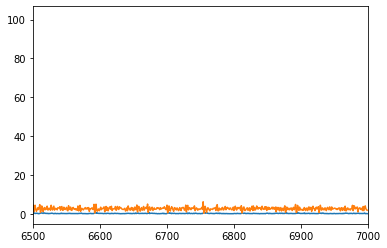

7100 [D loss: 0.158212, acc.: 96.88%] [G loss: 2.741632]
7200 [D loss: 0.216089, acc.: 93.75%] [G loss: 1.787884]
7300 [D loss: 0.161181, acc.: 96.88%] [G loss: 2.882665]
7400 [D loss: 0.248333, acc.: 96.88%] [G loss: 2.632259]
7500 [D loss: 0.256371, acc.: 90.62%] [G loss: 3.862967]


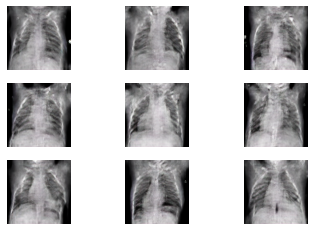

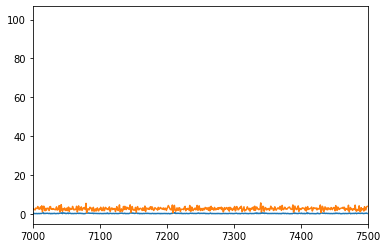

7600 [D loss: 0.335438, acc.: 84.38%] [G loss: 2.799412]
7700 [D loss: 0.260292, acc.: 93.75%] [G loss: 3.893561]
7800 [D loss: 0.310383, acc.: 84.38%] [G loss: 1.637791]
7900 [D loss: 0.452969, acc.: 71.88%] [G loss: 0.600321]
8000 [D loss: 0.190787, acc.: 93.75%] [G loss: 1.819016]


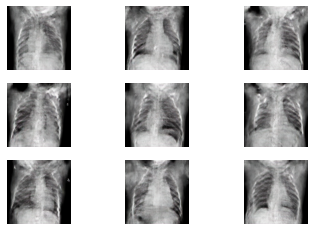

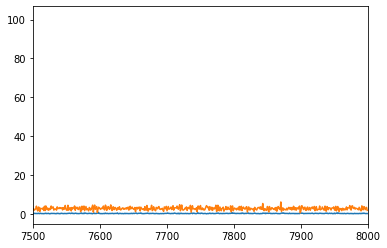

8100 [D loss: 0.193558, acc.: 90.62%] [G loss: 4.874888]
8200 [D loss: 0.091748, acc.: 100.00%] [G loss: 3.768547]
8300 [D loss: 0.291213, acc.: 93.75%] [G loss: 3.914522]
8400 [D loss: 0.290328, acc.: 84.38%] [G loss: 2.498316]
8500 [D loss: 0.162457, acc.: 93.75%] [G loss: 3.300251]


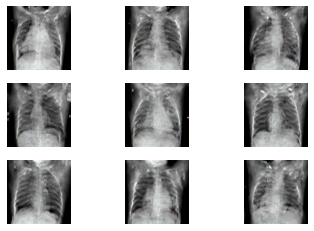

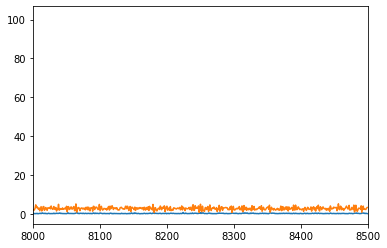

8600 [D loss: 0.230577, acc.: 90.62%] [G loss: 3.145028]
8700 [D loss: 0.328869, acc.: 90.62%] [G loss: 2.713541]
8800 [D loss: 0.166037, acc.: 93.75%] [G loss: 4.087276]
8900 [D loss: 0.153823, acc.: 96.88%] [G loss: 2.470268]
9000 [D loss: 0.001680, acc.: 100.00%] [G loss: 20.192772]


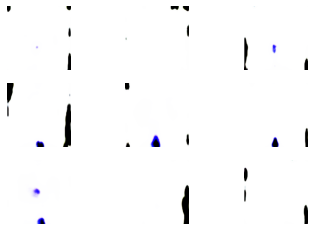

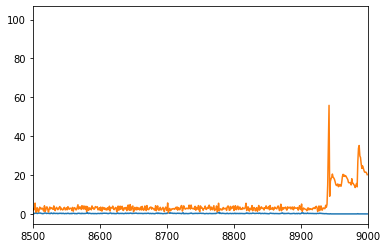

9100 [D loss: 0.000481, acc.: 100.00%] [G loss: 22.854427]
9200 [D loss: 0.000454, acc.: 100.00%] [G loss: 16.875048]
9300 [D loss: 0.002215, acc.: 100.00%] [G loss: 7.992962]
9400 [D loss: 0.000305, acc.: 100.00%] [G loss: 19.104832]
9500 [D loss: 0.000244, acc.: 100.00%] [G loss: 21.464352]


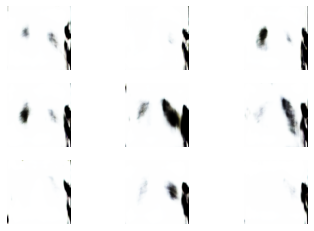

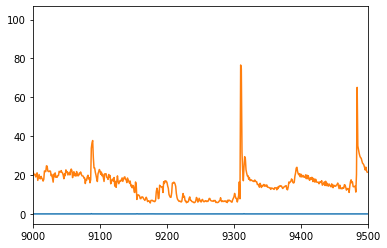

9600 [D loss: 0.047022, acc.: 100.00%] [G loss: 8.712509]
9700 [D loss: 0.036065, acc.: 100.00%] [G loss: 4.495713]
9800 [D loss: 0.273612, acc.: 84.38%] [G loss: 3.159964]
9900 [D loss: 0.177516, acc.: 93.75%] [G loss: 3.313422]
10000 [D loss: 0.224499, acc.: 96.88%] [G loss: 2.469267]


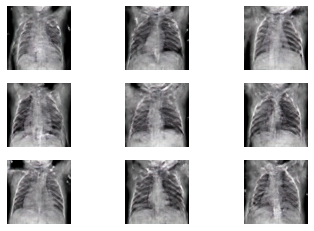

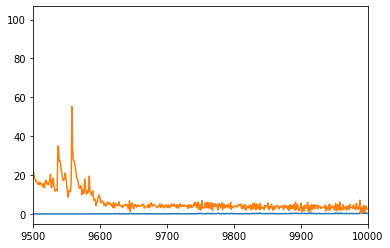

Models G/drive/MyDrive/ML/HW3/Models/RX1/D_model_10000.h5 saved.


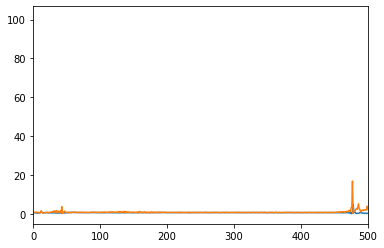

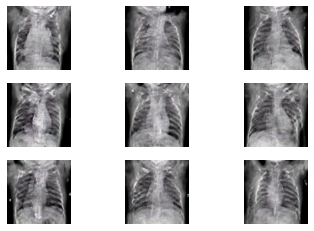

In [ ]:
gan.train(epochs=10000, batch_size=32, save_interval=100)
gan.save_model()
plt.subplots()
plt.xlim(0,500)
plt.plot(gan.d_loss, label='D loss')
plt.plot(gan.g_loss, label='G loss')
plt.show()
plt.close()
gan.show_images()

**Plot losses**

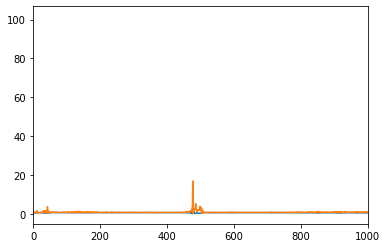

In [ ]:
plt.subplots()
plt.xlim(0,1000)
plt.plot(gan.d_loss, label='D loss')
plt.plot(gan.g_loss, label='G loss')
plt.show()
plt.close()

**Show examples of the generated images**

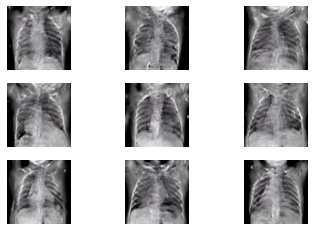

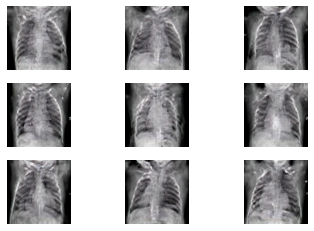

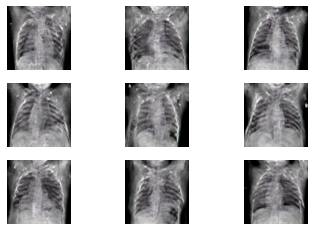

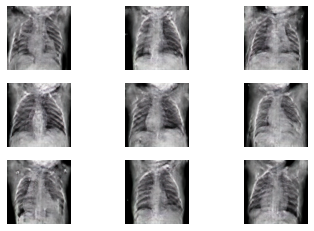

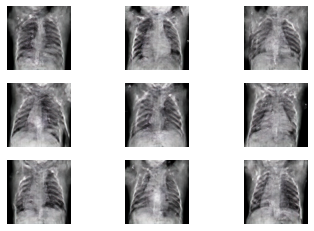

In [ ]:
i=0
while(i<5):
  gan.show_images()
  i=i+1

**Save the model**

In [ ]:
gan.save_model()

Models G/drive/MyDrive/ML/HW3/Models/RX1/D_model_10000.h5 saved.
